#**🚨 Before Running the Script Please Make Sure you have selected the Run Time as GPU**

#**Step 01: Installing the Packages**

In [ ]:
%%capture
!pip install super_gradients
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

#**🚨 Restart the Run Time**

#**Step 02: Importing all the required libraries**

In [1]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

The console stream is logged into C:\Users\prabh\sg_logs\console.log


[2024-01-19 16:19:46] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-01-19 16:19:46] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-01-19 16:19:46,977] torch.distributed.elastic.multiprocessing.redirects: [WARNING] NOTE: Redirects are currently not supported in Windows or MacOs.
c:\Users\prabh\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[2024-01-19 16:20:07] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-01-19 16:20:07] WARNING - export.py - Failed to import pytorch_quantization
[2024-01-19 16:20:07] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2024-01-19 16:20:07] WARNING - env_sanity_check.py - Failed to

In [2]:
from IPython.display import clear_output


In [3]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback



In [4]:
from super_gradients.training import models


#**Step 03: Setting the checkpoint directory and experiment name | Instantiated the trainer**

In [5]:
CHECKPOINT_DIR = 'checkpoints2'
trainer = Trainer(experiment_name='sign_yolonas_run2', ckpt_root_dir=CHECKPOINT_DIR)

#**Step 04: Exporting the Dataset from Roboflow into the Google Colab Notebook**

In [6]:

from roboflow import Roboflow
rf = Roboflow(api_key="IuYv6KOKs5p62rFSLvGa")
project = rf.workspace("david-lee-d0rhs").project("american-sign-language-letters")
dataset = project.version(6).download("yolov5")


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to American-Sign-Language-Letters-6 in yolov5pytorch::   3%|▎         | 45/1452 [00:00<00:03, 436.10it/s]

Extracting Dataset Version Zip to American-Sign-Language-Letters-6 in yolov5pytorch::  90%|█████████ | 1314/1452 [00:02<00:00, 554.23it/s]

#**Step 05: Load your dataset parameters into a dictionary**

You'll need to load your dataset parameters into a dictionary, specifically defining:

- path to the parent directory where your data lives
- the child directory names for training, validation, and test (if you have testing set) images and labels
- class names

In [7]:
dataset_params = {
    'data_dir':'C:/Users/prabh/Computervisionprojects/YOLO-NAS Sign Language Detection/American-Sign-Language-Letters-6',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['A', 'B', 'C', 'D', 'E', 'F', 'G','H', 'I', 'J', 'K', 'L','M','N','O', 'P', 'Q', 'R', 'S', 'T', 'U',  'V', 'W', 'X', 'Y', 'Z']
}



Extracting Dataset Version Zip to American-Sign-Language-Letters-6 in yolov5pytorch:: 100%|██████████| 1452/1452 [00:02<00:00, 546.73it/s]


#**Step 06: Pass the values for `dataset_params` into the `dataset_params` argument as shown below.**

In [8]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

#**Step 07: Inspect the Dataset Defined Earlier**

In [9]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

In [10]:
train_data.dataset.dataset_params['transforms'][1]

{'DetectionRandomAffine': {'degrees': 10.0, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

In [11]:
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42

#**Step 08: Plot a batch of training data with their augmentations applied to see what they look like**

Indexing dataset annotations: 100%|██████████| 72/72 [00:01<00:00, 49.75it/s]


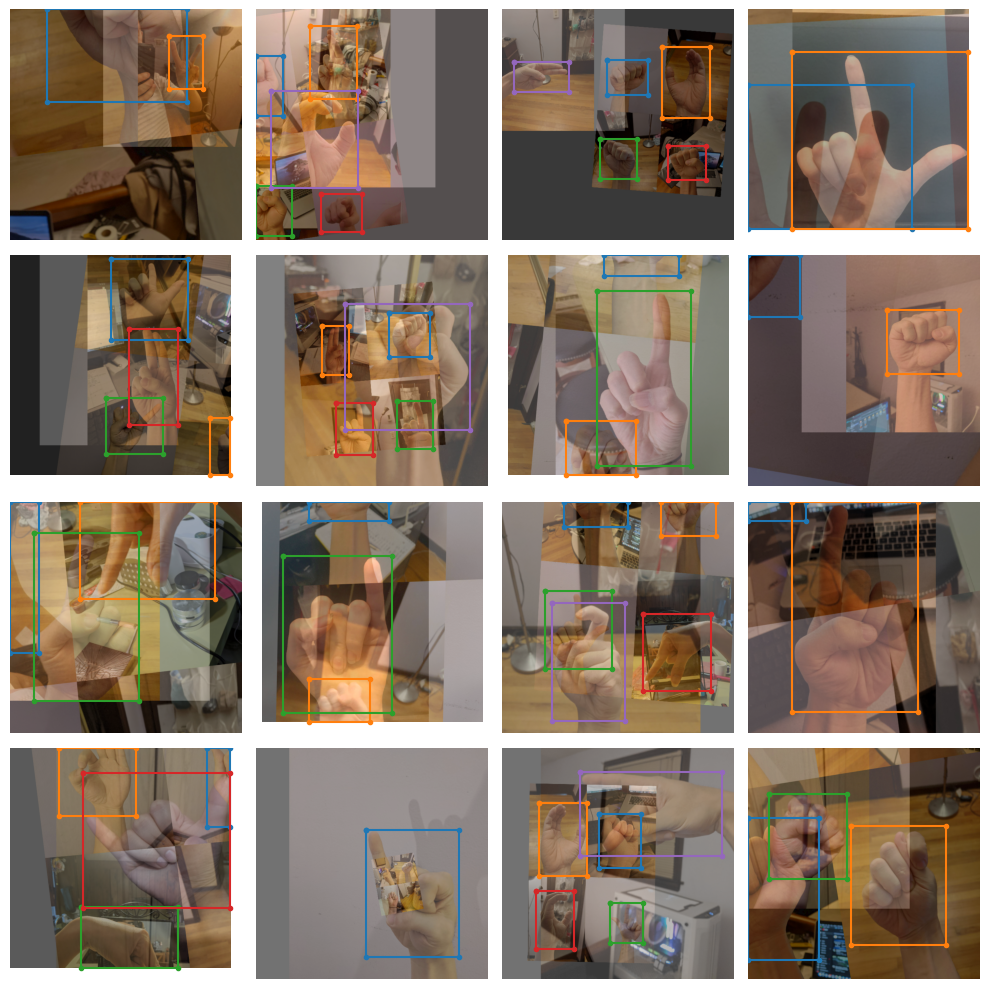

In [12]:
train_data.dataset.plot()

#**Step 09: Instantiating the model**


You saw how to instantiate the model for inference earlier. 

Below is how to instantiate the model for finetuning. Note you need to add the `num_classes` argument here.

Note, for this tutorial we are using `yolo_nas_s`, but SuperGradients has two other flavors of YOLONAS available to you: `yolo_nas_m` and `yolo_nas_l`.

In [13]:
model = models.get('yolo_nas_s', 
                   num_classes=len(dataset_params['classes']), 
                   pretrained_weights="coco"
                   )

[2024-01-19 16:21:57] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-01-19 16:21:57] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s


#**Step 10: 📊 Define metrics and training parameters**


We need to define the training parameters for your training run. 

Full details about the training parameters can be found [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/training_hyperparams/default_train_params.yaml).


### 🚨 There are a few **mandatory** arguments that we must define for training params 🚨

- `max_epochs` - Max number of training epochs

- `loss` - the loss function you want to use

- `optimizer` - Optimizer you will be using

- `train_metrics_list` - Metrics to log during training

- `valid_metrics_list` - Metrics to log during training

- `metric_to_watch` - metric which the model checkpoint will be saved according to

We can choose from a variety of `optimizer`'s such as: Adam, AdamW, SGD, Lion, or RMSProps. If you choose to change the defualt parameters of these optimizrs you pass them into `optimizer_params`. 


In [14]:
train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 25,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

#**Step 11: Download the Demo Videos**

In [15]:
!gdown "https://drive.google.com/uc?id=1bLlfh9gr6JxE9Wacw4xgv5FNijA7j9GZ&confirm=t"

In [16]:
!gdown "https://drive.google.com/uc?id=1kju9OOo05c5XTfrKuLvsZcxu_NPloQk_&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1bLlfh9gr6JxE9Wacw4xgv5FNijA7j9GZ&confirm=t
To: c:\Users\prabh\Computervisionprojects\YOLO-NAS Sign Language Detection\demonew1.mp4

  0%|          | 0.00/1.26M [00:00<?, ?B/s]
 42%|████▏     | 524k/1.26M [00:00<00:01, 706kB/s]
 83%|████████▎ | 1.05M/1.26M [00:01<00:00, 1.07MB/s]
100%|██████████| 1.26M/1.26M [00:01<00:00, 1.18MB/s]


Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1kju9OOo05c5XTfrKuLvsZcxu_NPloQk_&confirm=t

but Gdown can't. Please check connections and permissions.


#**Step 12: 🦾 Training the model**

You've covered a lot of ground so far:

✅ Instantiated the trainer

✅ Defined your dataset parameters and dataloaders

✅ Instantiated a model

✅ Set up your training parameters

### ⏳ Now, its time to train a model 

Training a model using a SuperGradients is done using the `trainer`.

It's as easy as...

In [23]:
trainer.train(model=model, 
              training_params=train_params, 
              train_loader=train_data, 
              valid_loader=val_data)

[2024-01-19 03:45:32] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240119_034532_832662`
[2024-01-19 03:45:32] INFO - sg_trainer.py - Checkpoints directory: checkpoints2\sign_yolonas_run2\RUN_20240119_034532_832662


The console stream is now moved to checkpoints2\sign_yolonas_run2\RUN_20240119_034532_832662/console_Jan19_03_45_32.txt


[2024-01-19 03:45:33] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
Mixed precision training is not supported on CPU. Disabling mixed precision. (i.e. `mixed_precision=False`)
getargs: The 'u' format is deprecated. Use 'U' instead.
[2024-01-19 03:46:56] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            504        (len(train_set))
    - Batch size per GPU:           16         (batch_size

#**Step 13: 🏆 Get the best trained model**

In [17]:
best_model = models.get('yolo_nas_s',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="checkpoints2/sign_yolonas_run2/ckpt_best.pth")

[2024-01-19 16:22:22] INFO - checkpoint_utils.py - Successfully loaded model weights from checkpoints2/sign_yolonas_run2/ckpt_best.pth EMA checkpoint.


#**Step 14: 🧐 Evaluating the best trained model on the test set**

In [18]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1, 
                                                   top_k_predictions=300, 
                                                   num_cls=len(dataset_params['classes']), 
                                                   normalize_targets=True, 
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, 
                                                                                                          nms_top_k=1000, 
                                                                                                          max_predictions=300,                                                                              
                                                                                                          nms_threshold=0.7)
                                                  ))

Testing:   0%|          | 0/5 [00:46<?, ?it/s]


KeyboardInterrupt: 

#**Step 15: 🔮 Predicting with the best model**



User provided device_type of 'cuda', but CUDA is not available. Disabling
[2024-01-19 16:25:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


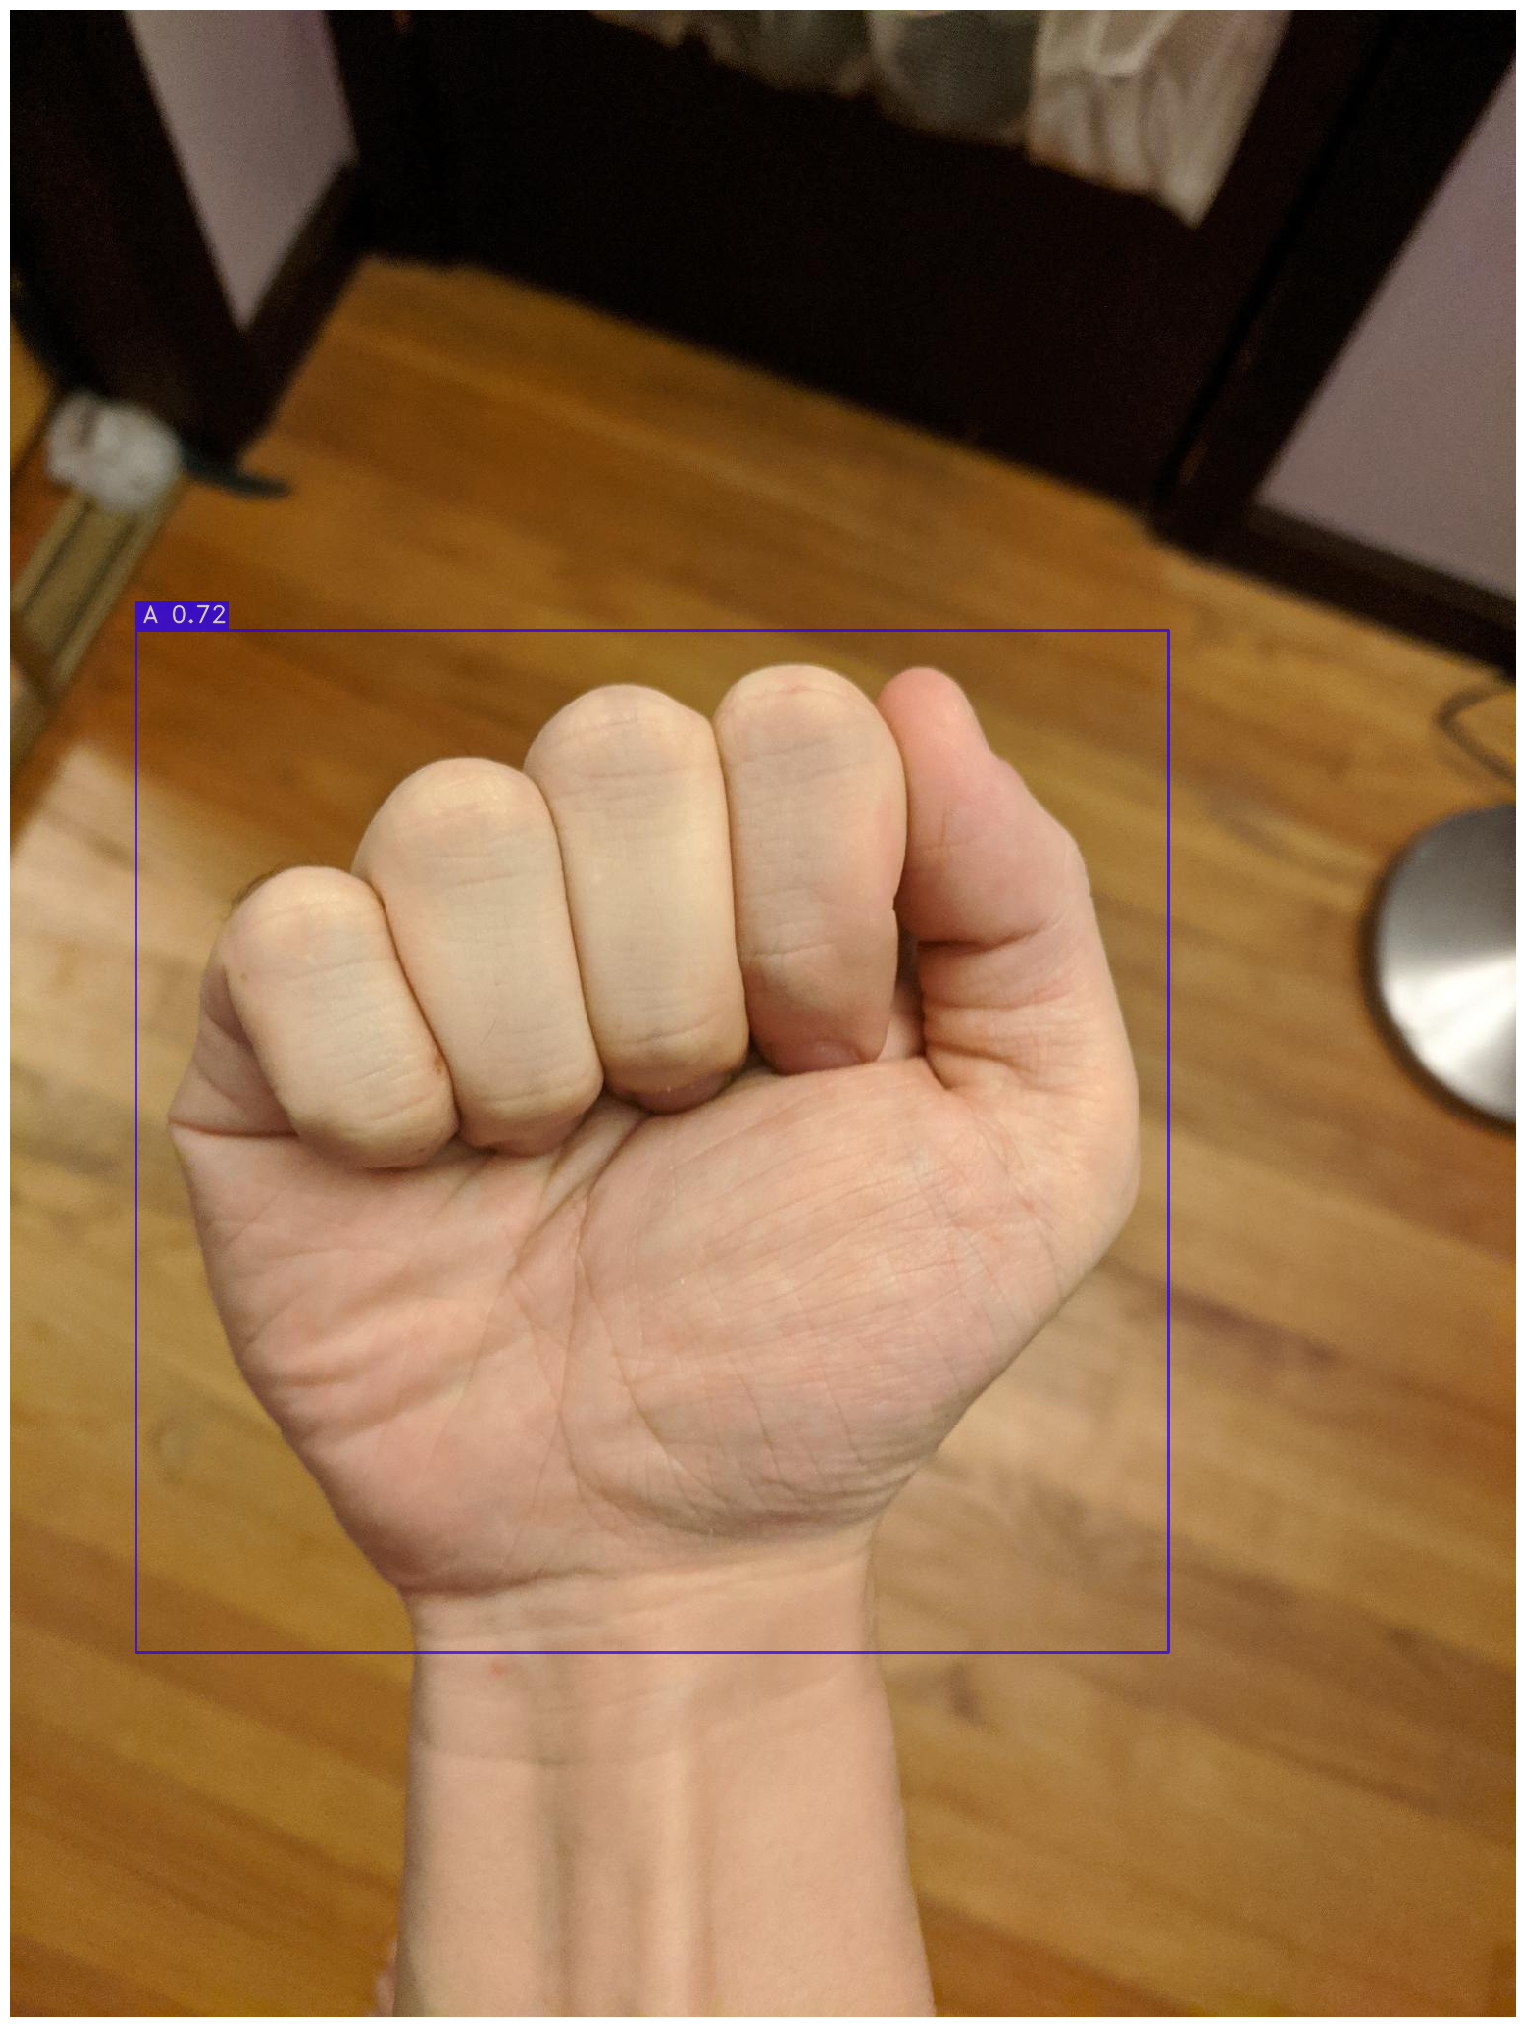

In [21]:
img_url = 'C:/Users/prabh/Computervisionprojects/YOLO-NAS Sign Language Detection/American-Sign-Language-Letters-6/valid/images/A9_jpg.rf.35b6a0735e0ff6acc94df948b5314389.jpg'
best_model.predict(img_url).show()

#**Step 16: Testing on Video 1**

In [25]:
input_video_path = f"C:/Users/prabh/Computervisionprojects/YOLO-NAS Sign Language Detection/demonew1.mp4"
output_video_path = "detections.mp4"

In [26]:
import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [27]:
best_model.to(device).predict(input_video_path).save(output_video_path)

Processing Video:   0%|          | 0/563 [00:00<?, ?it/s]User provided device_type of 'cuda', but CUDA is not available. Disabling
[2024-01-19 16:27:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
Processing Video:  95%|█████████▍| 534/563 [04:17<00:08,  3.27it/s]

Processing Video: 100%|██████████| 563/563 [04:25<00:00,  2.12it/s]


#**Display the Output Video**

In [28]:
!rm 'C:/Users/prabh/Computervisionprojects/YOLO-NAS Sign Language Detection/result_compressed.mp4'

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [29]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = 'C:/Users/prabh/Computervisionprojects/YOLO-NAS Sign Language Detection/detections.mp4'

# Compressed video path
compressed_path = "C:/Users/prabh/Computervisionprojects/YOLO-NAS Sign Language Detection/result_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/prabh/Computervisionprojects/YOLO-NAS Sign Language Detection/result_compressed.mp4'

#**Step 17: Testing on Video 2**

In [30]:
input_video_path = f"/content/demo5.mp4"
output_video_path = "detections2.mp4"

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [ ]:
best_model.to(device).predict(input_video_path).save(output_video_path)

#**Display the Output Video**

In [ ]:
!rm '/content/result_compressed.mp4'

In [ ]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = '/content/detections2.mp4'

# Compressed video path
compressed_path = "/content/result_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)